In [1]:
# -----------------------------------------------------------------------------
# 步骤 1: 导入所有必要的库
# -----------------------------------------------------------------------------
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
import time
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
from torch.optim.lr_scheduler import LambdaLR, CosineAnnealingLR
import torch.utils.checkpoint as checkpoint 
import os


/home2/lihaoyu/miniconda3/envs/gan-env/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [2]:
# -----------------------------------------------------------------------------
# 步骤 2: 全局超参数设置
# -----------------------------------------------------------------------------
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

BATCH_SIZE = 128
NUM_TOTAL_EPOCHS = 200
BASE_LR = 5e-4             # AdamW 推荐的基准学习率
NUM_WARMUP_EPOCHS = 5
GRAD_CLIP_MAX_NORM = 5.0   # 梯度裁剪最大范数

# MixUp/CutMix 参数
mixup_alpha = 1.0
cutmix_alpha = 1.0
cutmix_prob = 0.5          # 0.5 的概率使用 CutMix，否则使用 MixUp


Using device: cuda


In [ ]:
# -----------------------------------------------------------------------------
# 步骤 3: 解决 NameError 的关键操作：将辅助函数置于最前方
# -----------------------------------------------------------------------------

def window_partition(x, window_size):
    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows

def window_reverse(windows, window_size, H, W):
    B = int(windows.shape[0] / (H * W / window_size / window_size))
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return x

# MixUp + CutMix 辅助函数
def rand_bbox(size, lam):
    H, W = size[2], size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_h = int(H * cut_rat)
    cut_w = int(W * cut_rat)
    cy = np.random.randint(H)
    cx = np.random.randint(W)
    y1 = np.clip(cy - cut_h // 2, 0, H)
    y2 = np.clip(cy + cut_h // 2, 0, H)
    x1 = np.clip(cx - cut_w // 2, 0, W)
    x2 = np.clip(cx + cut_w // 2, 0, W)
    return x1, y1, x2, y2

def apply_mixup(inputs, targets, alpha=mixup_alpha):
    lam = np.random.beta(alpha, alpha)
    batch_size = inputs.size()[0]
    index = torch.randperm(batch_size).to(inputs.device)
    mixed_inputs = lam * inputs + (1 - lam) * inputs[index, :]
    targets_a, targets_b = targets, targets[index]
    return mixed_inputs, targets_a, targets_b, lam

def apply_cutmix(inputs, targets, alpha=cutmix_alpha):
    lam = np.random.beta(alpha, alpha)
    batch_size = inputs.size()[0]
    index = torch.randperm(batch_size).to(inputs.device)
    x1, y1, x2, y2 = rand_bbox(inputs.size(), lam)
    inputs_new = inputs.clone()
    inputs_new[:, :, y1:y2, x1:x2] = inputs[index, :, y1:y2, x1:x2]
    lam = 1 - ((x2 - x1) * (y2 - y1) / (inputs.size()[-1] * inputs.size()[-2]))
    targets_a, targets_b = targets, targets[index]
    return inputs_new, targets_a, targets_b, lam


In [4]:
# -----------------------------------------------------------------------------
# 步骤 4: Swin Transformer 模型结构定义 (核心组件)
# -----------------------------------------------------------------------------

class WindowAttention(nn.Module):
    def __init__(self, dim, window_size, num_heads, qkv_bias=True, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads)) 
        coords_h = torch.arange(self.window_size[0])
        coords_w = torch.arange(self.window_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w], indexing='ij'))
        coords_flatten = torch.flatten(coords, 1)
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()
        relative_coords[:, :, 0] += self.window_size[0] - 1
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)
        self.register_buffer("relative_position_index", relative_position_index)
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)
        trunc_normal_(self.relative_position_bias_table, std=.02)
        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, x, mask=None):
        B_, N, C = x.shape
        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))
        relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
            self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1).permute(2, 0, 1).contiguous()
        attn = attn + relative_position_bias.unsqueeze(0)
        if mask is not None:
            nW = mask.shape[0]
            attn = attn.view(B_ // nW, nW, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)
        attn = self.attn_drop(attn)
        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

class SwinTransformerBlock(nn.Module):
    def __init__(self, dim, input_resolution, num_heads, window_size=7, shift_size=0,
                 mlp_ratio=4., qkv_bias=True, drop=0., attn_drop=0., drop_path=0.,
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        if min(self.input_resolution) <= self.window_size:
            self.shift_size = 0
            self.window_size = min(self.input_resolution)
        self.norm1 = norm_layer(dim)
        self.attn = WindowAttention(
            dim, window_size=to_2tuple(self.window_size), num_heads=num_heads,
            qkv_bias=qkv_bias, attn_drop=attn_drop, proj_drop=drop)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(dim, mlp_hidden_dim),
            act_layer(),
            nn.Dropout(drop),
            nn.Linear(mlp_hidden_dim, dim),
            nn.Dropout(drop)
        )
        
        # 创新点：并行卷积分支 (Parallel Convolution Branch)
        # 旨在融合局部归纳偏置 (Local Inductive Bias) 与全局建模能力
        self.conv_branch = nn.Sequential(
            nn.Conv2d(dim, dim, kernel_size=3, padding=1, groups=dim), # Depthwise Conv
            nn.BatchNorm2d(dim),
            act_layer()
        )
        self.conv_scale = nn.Parameter(torch.ones(1) * 0.1) # 可学习的融合系数

    def create_mask(self, H, W):
        if self.shift_size > 0:
            img_mask = torch.zeros((1, H, W, 1))
            h_slices = (slice(0, -self.window_size), slice(-self.window_size, -self.shift_size), slice(-self.shift_size, None))
            w_slices = (slice(0, -self.window_size), slice(-self.window_size, -self.shift_size), slice(-self.shift_size, None))
            cnt = 0
            for h in h_slices:
                for w in w_slices:
                    img_mask[:, h, w, :] = cnt
                    cnt += 1
            # 这里的 window_partition 现在已经定义在全局范围
            mask_windows = window_partition(img_mask, self.window_size)
            mask_windows = mask_windows.view(-1, self.window_size * self.window_size)
            attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
            attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))
        else:
            attn_mask = None
        return attn_mask
    def forward(self, x):
        H, W = self.input_resolution
        B, L, C = x.shape
        shortcut = x
        x = self.norm1(x)
        x = x.view(B, H, W, C)
        
        # 并行卷积分支前向传播
        x_conv = x.permute(0, 3, 1, 2) # B, C, H, W
        x_conv = self.conv_branch(x_conv).permute(0, 2, 3, 1).view(B, L, C) # B, L, C
        
        if self.shift_size > 0:
            shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
            attn_mask = self.create_mask(H, W).to(x.device)
        else:
            shifted_x = x
            attn_mask = None
        # 这里的 window_partition 不再报错
        x_windows = window_partition(shifted_x, self.window_size).view(-1, self.window_size * self.window_size, C)
        attn_windows = self.attn(x_windows, mask=attn_mask)
        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, C)
        # 这里的 window_reverse 不再报错
        shifted_x = window_reverse(attn_windows, self.window_size, H, W)
        if self.shift_size > 0:
            x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
        else:
            x = shifted_x
        x = x.view(B, H * W, C)
        
        # 融合机制：Transformer 特征 + 卷积特征
        x = shortcut + self.drop_path(x) + self.drop_path(x_conv * self.conv_scale)
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x

class PatchMerging(nn.Module):
    def __init__(self, input_resolution, dim, norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False) 
        self.norm = norm_layer(4 * dim)
    def forward(self, x):
        H, W = self.input_resolution
        B, L, C = x.shape
        x = x.view(B, H, W, C)
        x0 = x[:, 0::2, 0::2, :]
        x1 = x[:, 1::2, 0::2, :]
        x2 = x[:, 0::2, 1::2, :]
        x3 = x[:, 1::2, 1::2, :]
        x = torch.cat([x0, x1, x2, x3], -1)
        x = x.view(B, -1, 4 * C)
        x = self.norm(x)
        x = self.reduction(x)
        return x

class PatchEmbed(nn.Module):
    def __init__(self, img_size=224, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]]
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]
        self.in_chans = in_chans
        self.embed_dim = embed_dim
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.norm = norm_layer(embed_dim) if norm_layer is not None else None
    def forward(self, x):
        B, C, H, W = x.shape
        x = self.proj(x).flatten(2).transpose(1, 2)
        if self.norm is not None:
            x = self.norm(x)
        return x

class BasicLayer(nn.Module):
    def __init__(self, dim, input_resolution, depth, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, drop=0., attn_drop=0.,
                 drop_path=0., norm_layer=nn.LayerNorm, downsample=None, use_checkpoint=False):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.use_checkpoint = use_checkpoint
        if isinstance(drop_path, list):
             dpr = drop_path
        else:
             dpr = [drop_path] * depth 
        self.blocks = nn.ModuleList([
            SwinTransformerBlock(dim=dim, input_resolution=input_resolution, num_heads=num_heads, window_size=window_size,
                                 shift_size=0 if (i % 2 == 0) else window_size // 2, mlp_ratio=mlp_ratio,
                                 qkv_bias=qkv_bias, drop=drop, attn_drop=attn_drop,
                                 drop_path=dpr[i], norm_layer=norm_layer)
            for i in range(depth)])
        self.downsample = downsample(input_resolution, dim=dim, norm_layer=nn.LayerNorm) if downsample is not None else None
    
    def forward(self, x):
        for blk in self.blocks:
            if self.use_checkpoint:
                x = checkpoint.checkpoint(blk, x)
            else:
                x = blk(x)
        if self.downsample is not None:
            x = self.downsample(x)
        return x

class SwinTransformer(nn.Module):
    def __init__(self, img_size=32, patch_size=2, in_chans=3, num_classes=10,
                 embed_dim=96, depths=[2, 2, 6, 2], num_heads=[3, 6, 12, 24],
                 window_size=4, mlp_ratio=4., qkv_bias=True, drop_rate=0.1, attn_drop_rate=0.0,
                 drop_path_rate=0.2, norm_layer=nn.LayerNorm, ape=False, patch_norm=True,
                 use_checkpoint=False, **kwargs):
        super().__init__()
        self.num_classes = num_classes
        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.num_features = int(embed_dim * 2**(self.num_layers - 1))
        
        self.patch_embed = PatchEmbed(img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim,
                                      norm_layer=norm_layer if patch_norm else None)
        patches_resolution = self.patch_embed.patches_resolution
        self.pos_drop = nn.Dropout(p=drop_rate)
        
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]
        
        self.layers = nn.ModuleList()
        for i_layer in range(self.num_layers):
            start_index = sum(depths[:i_layer])
            end_index = sum(depths[:i_layer + 1])
            layer = BasicLayer(dim=int(embed_dim * 2**i_layer),
                               input_resolution=(patches_resolution[0] // (2**i_layer), patches_resolution[1] // (2**i_layer)),
                               depth=depths[i_layer], num_heads=num_heads[i_layer], window_size=window_size, 
                               mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, drop=drop_rate, attn_drop=attn_drop_rate,
                               drop_path=dpr[start_index:end_index], 
                               norm_layer=norm_layer,
                               downsample=PatchMerging if (i_layer < self.num_layers - 1) else None,
                               use_checkpoint=use_checkpoint)
            self.layers.append(layer)

        self.norm = norm_layer(self.num_features)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.head = nn.Linear(self.num_features, num_classes) if num_classes > 0 else nn.Identity()

    def forward_features(self, x):
        x = self.patch_embed(x)
        x = self.pos_drop(x)
        for layer in self.layers:
            x = layer(x)
        x = self.norm(x)
        x = self.avgpool(x.transpose(1, 2))
        x = torch.flatten(x, 1)
        return x

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)
        return x


In [5]:

# -----------------------------------------------------------------------------
# 步骤 5: SOTA 数据增强和数据加载 (CIFAR-10)
# -----------------------------------------------------------------------------

NORM_MEAN = (0.4914, 0.4822, 0.4465)
NORM_STD = (0.2023, 0.1994, 0.2010)

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.AutoAugment(policy=transforms.AutoAugmentPolicy.CIFAR10),
    transforms.ToTensor(),
    transforms.Normalize(NORM_MEAN, NORM_STD),
    transforms.RandomErasing(p=0.25),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(NORM_MEAN, NORM_STD),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)



Files already downloaded and verified
Files already downloaded and verified


In [6]:

# -----------------------------------------------------------------------------
# 步骤 6: Warmup 调度器
# -----------------------------------------------------------------------------
class LinearWarmup(LambdaLR):
    def __init__(self, optimizer, warmup_epochs, last_epoch=-1):
        def lr_lambda(epoch):
            if epoch < warmup_epochs:
                return (epoch + 1) / warmup_epochs
            return 1
        super().__init__(optimizer, lr_lambda, last_epoch)



In [7]:

# -----------------------------------------------------------------------------
# 步骤 7: 改进的 Train & Test 函数 (集成 MixUp/CutMix 和 Gradient Clipping)
# -----------------------------------------------------------------------------
def train(epoch, net, trainloader, optimizer, criterion): 
    net.train()
    total, correct, total_loss = 0, 0, 0
    t0 = time.time()

    for inputs, targets in trainloader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        # MixUp/CutMix Logic
        r = np.random.rand()
        if r < cutmix_prob:
            inputs, targets_a, targets_b, lam = apply_cutmix(inputs, targets)
        else:
            inputs, targets_a, targets_b, lam = apply_mixup(inputs, targets)

        optimizer.zero_grad()
        outputs = net(inputs)

        # 混合损失计算
        loss = lam * criterion(outputs, targets_a) + \
             (1 - lam) * criterion(outputs, targets_b)

        loss.backward()
        
        # 梯度裁剪
        nn.utils.clip_grad_norm_(net.parameters(), max_norm=GRAD_CLIP_MAX_NORM) 
        
        optimizer.step()

        total_loss += loss.item()
        _, pred = outputs.max(1)
        total += targets.size(0)

        # MixUp/CutMix 混合准确率计算
        correct += (lam * pred.eq(targets_a).sum().item() + 
                    (1 - lam) * pred.eq(targets_b).sum().item())

    print(f"Train Epoch {epoch+1:3d} | Loss: {total_loss/len(trainloader):.4f} "
          f"| Acc (approx): {100.*correct/total:.2f}% | Time: {time.time()-t0:.1f}s")


def test(epoch, net, testloader, criterion):
    net.eval()
    correct, total = 0, 0
    total_loss = 0

    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            total_loss += loss.item()
            _, pred = outputs.max(1)
            total += targets.size(0)
            correct += pred.eq(targets).sum().item()

    acc = 100.*correct/total
    print(f"Test | Loss: {total_loss/len(testloader):.4f} "
          f"| Acc: {acc:.2f}% ({correct}/{total})")
    return acc


In [8]:

# -----------------------------------------------------------------------------
# 步骤 8: 模型实例化和主训练循环
# -----------------------------------------------------------------------------

# --- Swin Transformer 配置 ---
swin_config = {
    "img_size": 32,
    "patch_size": 2,        
    "in_chans": 3,
    "num_classes": 10,
    "embed_dim": 96,        
    "depths": [2, 2, 6, 2], 
    "num_heads": [3, 6, 12, 24],
    "window_size": 4,       
    "drop_path_rate": 0.2,
    "drop_rate": 0.1,       
    "attn_drop_rate": 0.0,
}

# 实例化 Swin Transformer 模型
swin_net = SwinTransformer(**swin_config).to(DEVICE)
print(f"--- 实例化 Swin Transformer (Swin-T) ---")
print(swin_net)

# 优化器: AdamW
optimizer_swin = optim.AdamW(swin_net.parameters(), lr=BASE_LR, weight_decay=0.05)


# 学习率调度器设置
scheduler_main = CosineAnnealingLR(
    optimizer_swin, 
    T_max=NUM_TOTAL_EPOCHS - NUM_WARMUP_EPOCHS, 
    eta_min=1e-6 # 最小学习率
)

scheduler_warmup = LinearWarmup(optimizer_swin, warmup_epochs=NUM_WARMUP_EPOCHS)


# --- Main Loop ---
best_acc = 0
print(f"\n--- 开始 {NUM_TOTAL_EPOCHS} 轮 Swin Transformer 训练 ---")

for epoch in range(NUM_TOTAL_EPOCHS):
    # 训练步骤
    train(epoch, swin_net, trainloader, optimizer_swin, criterion) 
    # 测试步骤
    acc = test(epoch, swin_net, testloader, criterion)
    # 学习率更新逻辑
    if epoch < NUM_WARMUP_EPOCHS:
        scheduler_warmup.step()
    else:
        scheduler_main.step() 
    current_lr = optimizer_swin.param_groups[0]['lr']
    print(f"   [LR] Current LR = {current_lr:.6f}")
    if acc > best_acc:
        best_acc = acc
        torch.save(swin_net.state_dict(), "swin_transformer_sota_best.pth")
        print(f">>>> Saved new best model ({best_acc:.2f}%) <<<<")
    print("-" * 60)

print("Training finished. Best Acc:", best_acc)

--- 实例化 Swin Transformer (Swin-T) ---
SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 96, kernel_size=(2, 2), stride=(2, 2))
    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  )
  (pos_drop): Dropout(p=0.1, inplace=False)
  (layers): ModuleList(
    (0): BasicLayer(
      (blocks): ModuleList(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=96, out_features=96, bias=True)
            (proj_drop): Dropout(p=0.1, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path): Identity()
          (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (0): Linear(in_features=96, out_features=384, bias=True)
            (1): GEL

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9802322e-08..0.96862745].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9802322e-08..0.827451].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9802322e-08..1.0].


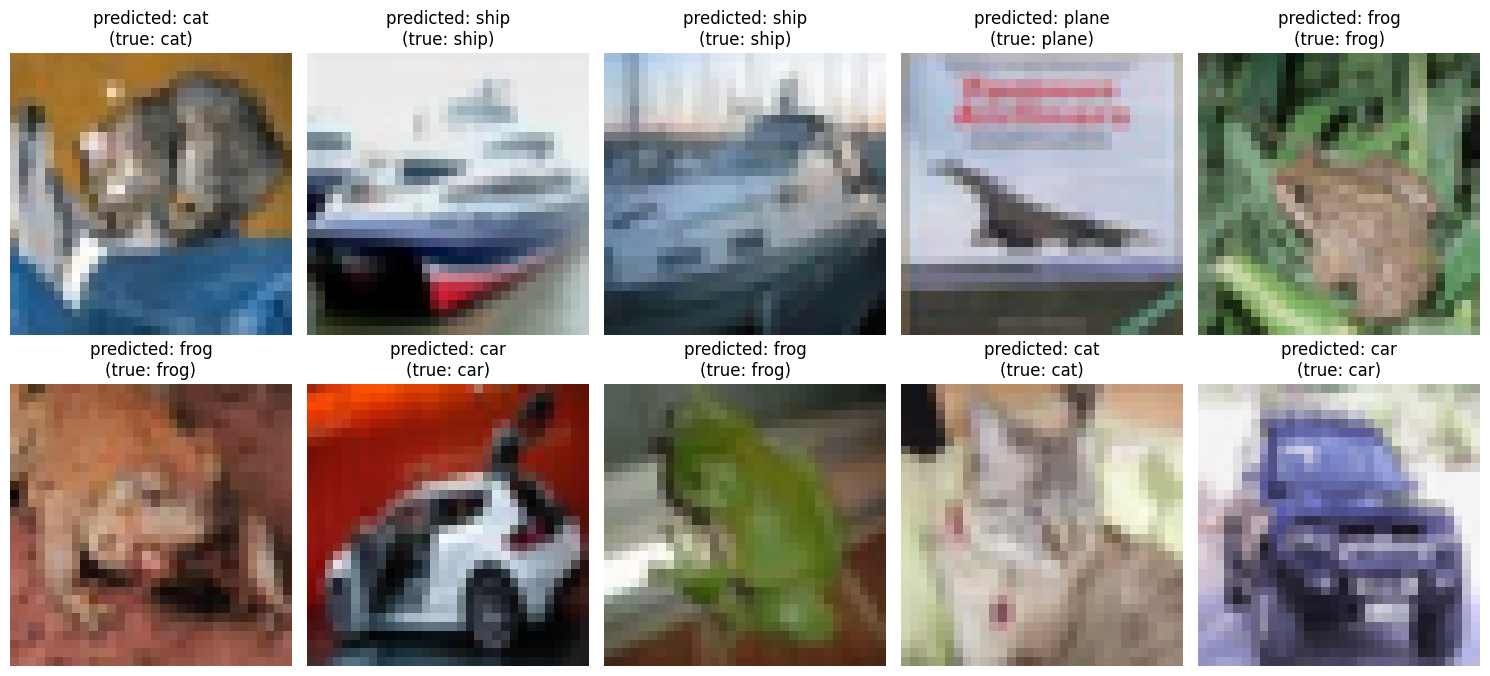

In [12]:
import matplotlib.pyplot as plt
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
def visualize_predictions(net, loader, num_images=10):
    net.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 7))
    with torch.no_grad():
        # 从测试数据加载器中获取一个批次
        dataiter = iter(loader)
        images, labels = next(dataiter)
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = net(images)
        _, preds = torch.max(outputs, 1)
        for i in range(images.size(0)):
            if images_so_far >= num_images:
                break
            images_so_far += 1
            ax = plt.subplot(num_images // 5, 5, images_so_far)
            ax.axis('off')
            ax.set_title(f'predicted: {classes[preds[i]]}\n(true: {classes[labels[i]]})')
            # 反标准化并显示图像
            img = images[i].cpu()
            img[0] = img[0] * 0.2023 + 0.4914
            img[1] = img[1] * 0.1994 + 0.4822
            img[2] = img[2] * 0.2010 + 0.4465
            npimg = img.numpy()
            plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.tight_layout()
        plt.show()
# 使用训练好的优化模型进行可视化
visualize_predictions(swin_net, testloader)